In [1]:
import numpy as np 
import pandas as pd 
import os
import gc
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm


AUTOTUNE = tf.data.experimental.AUTOTUNE

In [2]:
img_size = 512
BASE_PATH = "./data/".format(size=img_size)
collection = pd.read_csv(os.path.join(BASE_PATH,"train.csv" ))
collection['filepath'] = [os.path.join(BASE_PATH,"train",id_+'.jpg')for id_ in collection['image_id']]
collection.head()

,boxes,label,StudyInstanceUID,image_id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,filepath
0,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,000a312787f2,0,1,0,0,./data/train/000a312787f2.jpg
1,NaN,none 1 0 0 1 1,ff0879eb20ed,000c3a3f293f,1,0,0,0,./data/train/000c3a3f293f.jpg
2,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,0012ff7358bc,0,1,0,0,./data/train/0012ff7358bc.jpg
3,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,001398f4ff4f,0,0,0,1,./data/train/001398f4ff4f.jpg
4,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,001bd15d1891,0,1,0,0,./data/train/001bd15d1891.jpg


In [ ]:
print(len(collection))

<AxesSubplot:>

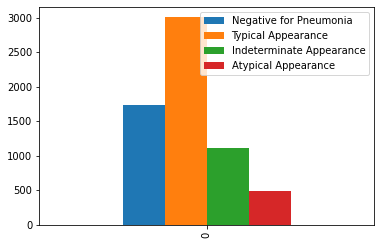

In [4]:
# print(collection["Negative for Pneumonia"].value_counts()[1])
neg_pneu = collection["Negative-Pneumonia"].value_counts()[1]
typ_app = collection["Typical Appearance"].value_counts()[1]
ind_app = collection["Indeterminate Appearance"].value_counts()[1]
atyp_app = collection["Atypical Appearance"].value_counts()[1]
lst = [neg_pneu, typ_app, ind_app, atyp_app]
plt_df = pd.DataFrame(lst)
plt_T = plt_df.T
plt_T.columns = ["Negative-Pneumonia", "Typical Appearance", "Indeterminate Appearance", "Atypical Appearance"]
plt_T.plot.bar()

/state/partition1/job-19599800/ipykernel_3131130/801819081.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  collection.hist(ax = ax)


array([[<AxesSubplot:title={'center':'Negative for Pneumonia'}>,
        <AxesSubplot:title={'center':'Typical Appearance'}>],
       [<AxesSubplot:title={'center':'Indeterminate Appearance'}>,
        <AxesSubplot:title={'center':'Atypical Appearance'}>]],
      dtype=object)

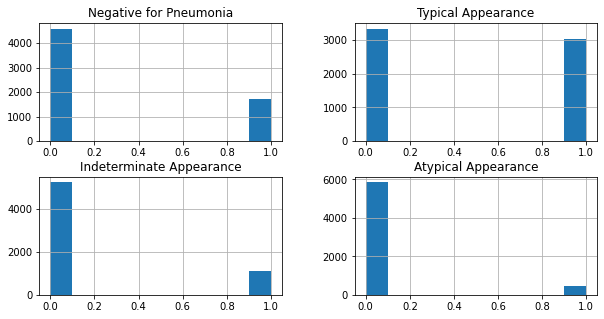

In [5]:
# collection.hist(bins = 10)
fig = plt.figure(figsize = (10,5))
ax = fig.gca()
collection.hist(ax = ax)

In [6]:
target = np.array(collection[['Negative for Pneumonia','Typical Appearance','Indeterminate Appearance','Atypical Appearance']])

In [7]:
X_train, X_test, y_train, y_test  = train_test_split(collection.filepath, target, test_size=0.33, random_state=42)
print(f"train shape: {X_train.shape}- y_train shape: {y_train.shape}")
print(f"test shape: {X_test.shape}- y_test shape: {y_test.shape}")

train shape: (4243,)- y_train shape: (4243, 4)
test shape: (2091,)- y_test shape: (2091, 4)


In [8]:
num_classes = 4
input_shape = (512, 512, 1)

In [68]:
learning_rate = 1e-4 #0.001
weight_decay = 0.0001
batch_size = 64 #[64, 128, 256, 512]
num_epochs = 100
image_size = 224 #224 
patch_size = 20 #[16, 20]
num_patches = (image_size // patch_size) ** 2
projection_dim = 64  #64,128,256,514
num_heads = 12 #2,4,6,8,12
# Size of the transformer layers
transformer_units = [projection_dim * 2, 
                     projection_dim,
                    ]  
transformer_layers = 3 #3,8  
mlp_head_units = [256] #[1024,512,256] 



In [69]:
@tf.function
def load(image_file, target):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)

    image_ = tf.cast(image, tf.float32)
    return image_, target

In [70]:
train_loader = (
    tf.data.Dataset
    .from_tensor_slices((X_train,y_train))
    .map(load, num_parallel_calls=AUTOTUNE)
    .shuffle(7)
    .batch(batch_size)
)
test_loader = (
    tf.data.Dataset
    .from_tensor_slices((X_test,y_test))
    .map(load, num_parallel_calls=AUTOTUNE)
    .shuffle(7)
    .batch(batch_size)
)

In [71]:
train_batch = (
    tf.data.Dataset
    .from_tensor_slices((X_train,y_train))
    .map(load, num_parallel_calls=AUTOTUNE)
    .shuffle(7)
    .batch(X_train.shape[0]-100)
)

In [72]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.Normalization(),
        layers.experimental.preprocessing.Resizing(image_size, image_size),
#         layers.experimental.preprocessing.RandomCrop(image_size , image_size, seed=None, ),
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(factor=0.2),
        layers.experimental.preprocessing.RandomZoom(
            height_factor = 0.2, width_factor = 0.2
        ),
    ],
     name="data_augmentation",
)
CompleteBatchData  = next(iter(train_batch))[0]
data_augmentation.layers[0].adapt(CompleteBatchData)

In [73]:
del CompleteBatchData
gc.collect()

7854

In [74]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation = tf.nn.relu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [75]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size
        
    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes = [1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        print(patches.shape)
        return patches 

(1, 224, 224, 1)
(1, 121, 400)
Image size: 224 X 224
Patch size: 20 X 20
Patches per image: 121
Elements per patch: 400


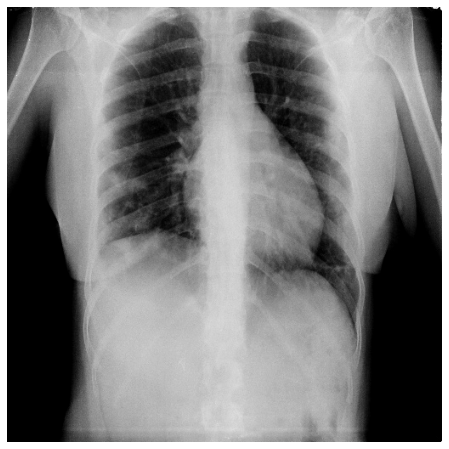

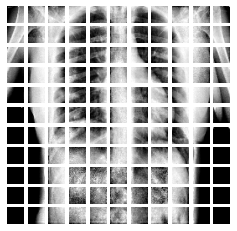

In [76]:
plt.figure(figsize=(8, 8))
image = next(iter(train_loader))[0][5]
plt.imshow(image, cmap='gray')
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
print(resized_image.shape)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))

plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 1))
    plt.imshow(patch_img,cmap='gray')
    plt.axis("off")

In [77]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_of_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units = projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim = num_patches, output_dim = projection_dim
        )
    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encode = self.projection(patch) + self.position_embedding(positions)
        return encode

In [79]:
def vit_model():
    inputs = layers.Input(shape=input_shape)
    augmented = data_augmentation(inputs)   #data augmentation 
    patches = Patches(patch_size)(augmented) # creation of patch sizes for defined patch size of 16
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)  #encoding of patches 
    
    # Transformer block
    for _ in range(transformer_layers):
        x1 = layers.BatchNormalization()(encoded_patches) #Batch Normalization Layer 1
        # Multi head attention layer
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches]) # skip connection 1
        x3 = layers.BatchNormalization()(x2) #Batch Normalization Layer 2
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1) # Multilayer perceptron block
        encoded_patches = layers.Add()([x3, x2]) # skip connection 2
        
    # Create a [batch_size, projection_dim] tensor
    representation = layers.LayerNormalization()(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    features = mlp(representation, hidden_units = mlp_head_units, dropout_rate=0.5) #MLP Custom block
    logits = layers.Dense(num_classes, activation='softmax')(features) # Classify outputs.
    model = keras.Model(inputs=inputs, outputs=logits)  # create keras model
    return model

In [80]:
def experiment(model):
#     optimizer = optimizer = tf.keras.optimizers.Adam(learning_rate)
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )
#     optimizer = tfa.optimizers.NovoGrad(
#         lr=1e-3,
#         beta_1=0.9,
#         beta_2=0.999,
#         weight_decay=0.001,
#         grad_averaging=False
#     )
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            keras.metrics.AUC( name="AUC"),
        ],
     )
    # Create a learning rate scheduler callback.
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=5
    )
    # Create an early stopping callback.
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    )
    checkpoint_filepath = "./tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )
    history = model.fit(train_loader ,
                        batch_size=batch_size,
                        epochs=num_epochs,
                        validation_data=test_loader,
                        callbacks=[checkpoint_callback],)
    model.load_weights(checkpoint_filepath)
    _, accuracy, auc = model.evaluate(test_loader)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test AUC: {round(auc * 100, 2)}%")
    return history

In [81]:
vit_classifier = vit_model()
vit_classifier.summary()

(None, None, 400)
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 data_augmentation (Sequential)  (None, 224, 224, 1)  3          ['input_4[0][0]']                
                                                                                                  
 patches_8 (Patches)            (None, None, 400)    0           ['data_augmentation[0][0]']      
                                                                                                  
 patch_encoder_3 (PatchEncoder)  (None, 121, 64)     33408       ['patches

In [82]:
history = experiment(vit_classifier)

Epoch 1/100
(None, None, 400)
(None, None, 400)
67/67 [==============================] - 12s 132ms/step - loss: 2.1123 - accuracy: 0.3677 - AUC: 0.6292 - val_loss: 1.2375 - val_accuracy: 0.4696 - val_AUC: 0.7167
Epoch 2/100
67/67 [==============================] - 8s 126ms/step - loss: 1.4487 - accuracy: 0.4162 - AUC: 0.6719 - val_loss: 1.2127 - val_accuracy: 0.4811 - val_AUC: 0.7351
Epoch 3/100
67/67 [==============================] - 8s 124ms/step - loss: 1.2948 - accuracy: 0.4473 - AUC: 0.6937 - val_loss: 1.2035 - val_accuracy: 0.4811 - val_AUC: 0.7354
Epoch 4/100
67/67 [==============================] - 8s 123ms/step - loss: 1.2376 - accuracy: 0.4740 - AUC: 0.7145 - val_loss: 1.1882 - val_accuracy: 0.4849 - val_AUC: 0.7418
Epoch 5/100
67/67 [==============================] - 8s 123ms/step - loss: 1.2150 - accuracy: 0.4789 - AUC: 0.7272 - val_loss: 1.1767 - val_accuracy: 0.4969 - val_AUC: 0.7478
Epoch 6/100
67/67 [==============================] - 8s 123ms/step - loss: 1.2152 - accu

dict_keys(['loss', 'accuracy', 'AUC', 'val_loss', 'val_accuracy', 'val_AUC'])


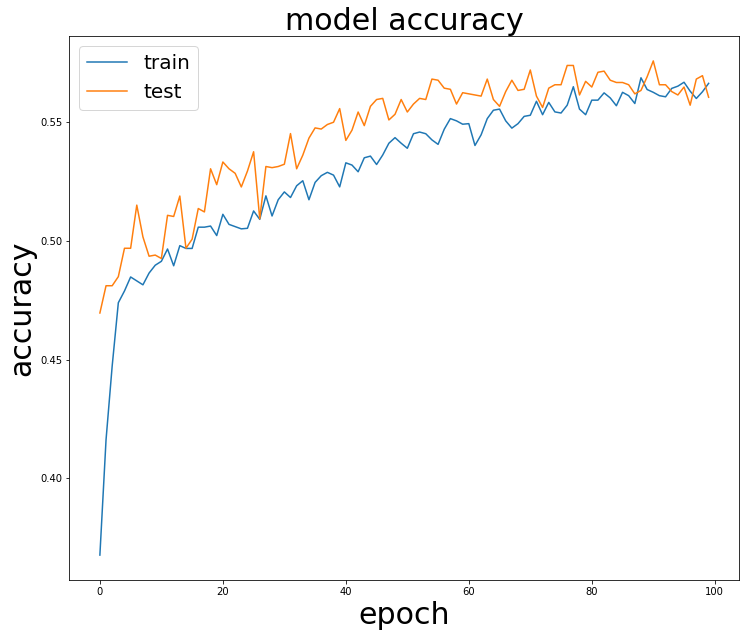

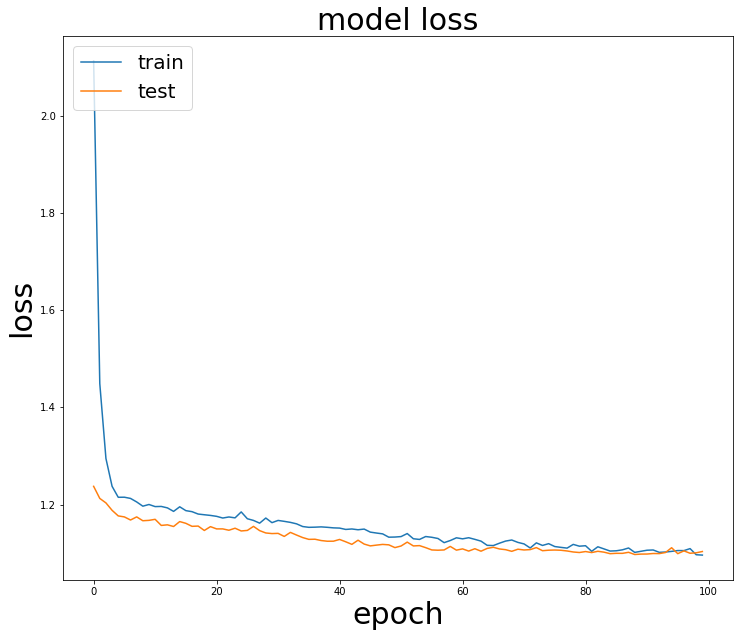

In [83]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.figure(figsize=(12,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy',fontsize=30)
plt.ylabel('accuracy',fontsize=30)
plt.xlabel('epoch',fontsize=30)
plt.legend(['train', 'test'], loc='upper left',prop={'size': 20})
plt.show()
# summarize history for loss
plt.figure(figsize=(12,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss',fontsize=30)
plt.ylabel('loss',fontsize=30)
plt.xlabel('epoch',fontsize=30)
plt.legend(['train', 'test'], loc='upper left',prop={'size': 20})
plt.show()

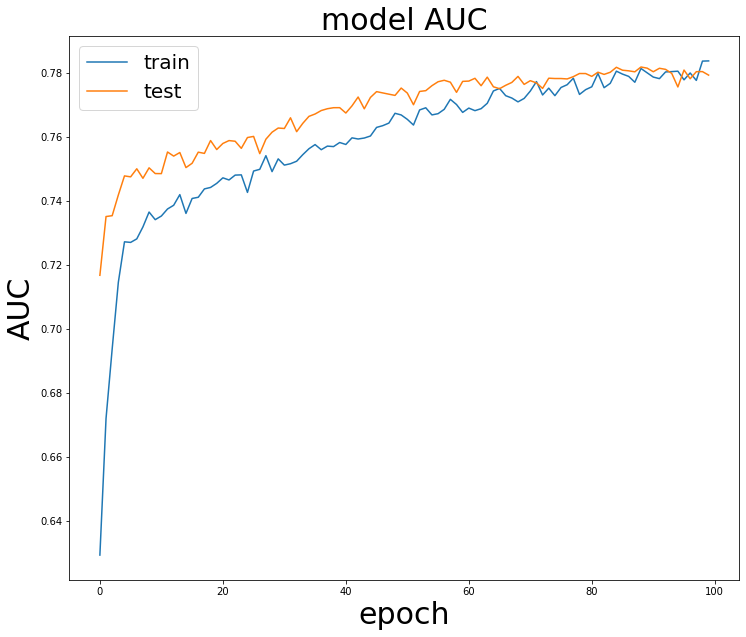

In [84]:
# summarize history for loss
plt.figure(figsize=(12,10))
plt.plot(history.history['AUC'])
plt.plot(history.history['val_AUC'])
plt.title('model AUC',fontsize=30)
plt.ylabel('AUC',fontsize=30)
plt.xlabel('epoch',fontsize=30)
plt.legend(['train', 'test'], loc='upper left',prop={'size': 20})
plt.show()

In [196]:
vit_classifier.load_weights("./tmp/checkpoint")

In [86]:
def get_img_array(img):
    array = keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

In [94]:
test_image = next(iter(test_loader))[0][5]
img_array =get_img_array(test_image)
# Remove last layer's softmax
vit_classifier.layers[-1].activation = None
preds = vit_classifier.predict(img_array)
print("Predicted:\n" +"Negative for Pneumonia: \
    {p1}\nTypical Appearance: {p2}\nIndeterminate Appearance: \
    {p3}\nAtypical Appearance: {p4}".format(p1=preds[0][0], \
                                            p2=preds[0][1],p3=preds[0][2],p4=preds[0][3]))

Predicted:
Negative for Pneumonia:     -0.1935298591852188
Typical Appearance: 0.07932496070861816
Indeterminate Appearance:     -0.5532732009887695
Atypical Appearance: -1.247002124786377
